# Housing Price Prediction : Regression

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해보기

Training : 404

Test : 102

Total : 506

### 보스턴 주택 데이터셋 로드

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

print(train_data.shape) # 404개의 훈련 샘플
print(test_data.shape) # 102개의 테스트 샘플
# 13개의 수치 특성이 존재 (1인당 범죄율, 주택당 평균 방의 개수, 고속도로 접근성 ...)

print(train_targets) # 1970년대 가격 (1만 달러에서 5만 달러 사이)

Using TensorFlow backend.


(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

### 데이터 정규화 (표준편차)

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 모델 정의

In [3]:
from keras import models
from keras import layers
    
def build_model(): # 동일한 모델을 여러번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) # mse 손실 함수 : 평쥰 제곱 오차(mean squared error)
    # 에측과 타깃 사이 거리의 제곱
    return model

### K-겹 검증을 사용한 훈련 검증

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않음)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores) # 검증 세트가 달라 검증 점수의 변화가 큰 것을 확인할 수 있다.
print(np.mean(all_scores)) # 평균값은 각각의 점수보다 훨씬 신뢰할 수 있다.

처리중인 폴드 # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
[2.1220064080587706, 2.2178340831605516, 2.869513181176516, 2.375157081254638]
2.396127688412619


### 각 폴드에서 검증 점수를 로그에 저장

In [5]:
num_epochs = 500 # 보다 오랫동안 훈련
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않음)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


### K-겹 검증 점수 평균을 기록하기

모든 폴드에 대해 에포크의 MAE 점수 평균을 계산

In [6]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 검증 점수 그래프

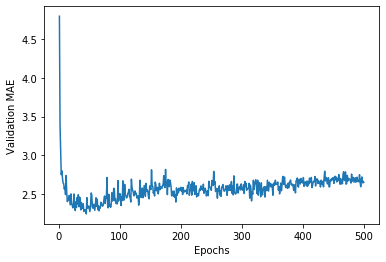

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title=('Validated MAE by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기

범위가 크고 변동이 심해 보기가 어려운 그래프를 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외하고,

부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균(exponetial moving average)으로 대체

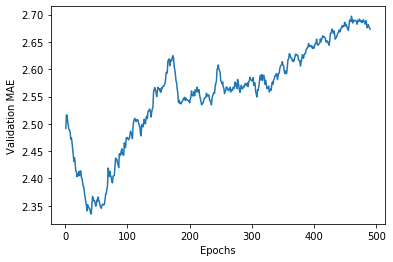

In [8]:
 def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

'''
지수 이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나
이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1 - factor)를 곱해 합산한 것을 가리킴
'''

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 최종 모델 훈련하기

In [9]:
model = build_model() # 새롭게 컴파일된 모델을 얻는다.
model.fit(train_data, train_targets, # 전체 데이터로 훈련시킨다.
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score) # 최종 결과

102/102 [==============================] - 0s 3ms/step
2.69433687247482


## 정리

- 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용한다.


    - 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수이다.
    
    
- 비슷하게 회긔에서 사용되는 평가 지표는 분류와 다르다. 


    - 정확도 개념은 회귀에 적용되지 않는다.
    
    - 일반적인 회귀 지표는 평균 절대 오차(MAE)이다.
    
    
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정을 해야한다.


- 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 평가 방법이다.


- 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋다.


    - 일반적으로 1개 또는 2개